In [1]:
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import colors

import astropy.io.fits as pyfits
import astropy.wcs as wcs

import os
import time

from scipy.optimize import curve_fit
from scipy.stats import kstest

In [2]:
## import functions
import GMM_plot_library as pGMM
import GMM_functions as fGMM
import velocity_axis_datacube as vax

# Gaussian Mixture model example
- Works for a 3D spectral datacube, clusters data cube based on spectra morphology (see Kabanovic+2020 for a description)
- Here, the GMM clustering is applied to RCW 79

In [3]:
#### User input ####

## input for the data file
path_file = 'data/'
name_file = 'RCW79_CII_PCA_20_8_0p5_clean.fits'
unit_integrated_intensity = '$\int$T$_{mb}$dv (K km s$^{-1}$)'

## plotting options 
dpi_val = 300
path_plots = 'plots/'
save_name = 'GMM_RCW79.pdf'

## input for the Gaussian Mixture Models
n_comps_min = 1
n_comps_max = 4#21

n_comps_min1 = 1
n_comps_max1 = 4#21

## information for the observational information
noise_rms_obs = 0.6 ## K
min_velocity = -70. ## km/s
max_velocity = -25. ## km/s
unit_intensity = "T$_{mb}$ (K)"
unit_z_axis = "v (km s$^{-1}$)"

## spectral resolutions of the resampled data (need to be higher than the native velocity resolution)
dv_resamps = [1., 1.5, 2.] ## in km/s

## Boolean to determine whether to work with decimate or resample
resample_bool = False 

########################

## Execute the script

In [4]:
## get the data and header information
hdu = pyfits.open(path_file + name_file)
hdu.info()
data = hdu[0].data
header = hdu[0].header

## store the spectral information (in km/s)
dv = 0.001*header['CDELT3']
crval = 0.001*header['CRVAL3']
crpix = header['CRPIX3']
print(dv)

## store the WCS information
header_c = header.copy()
header_c['NAXIS'] = 2
del header_c['NAXIS3']
del header_c['CTYPE3']
del header_c['CRVAL3']
del header_c['CDELT3']
del header_c['CRPIX3']
del header_c['CROTA3']

w = wcs.WCS(header_c)

Filename: data/RCW79_CII_PCA_20_8_0p5_clean.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      42   (188, 188, 160)   float32   
0.5


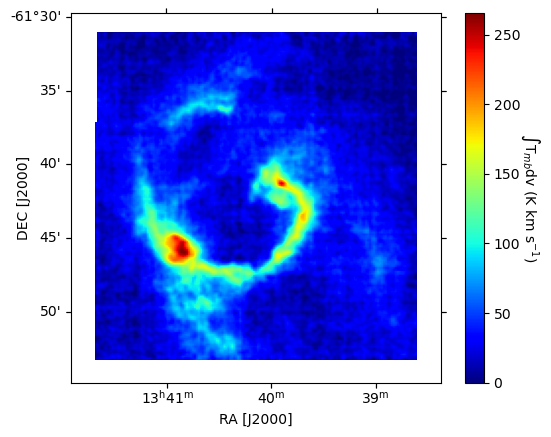

In [5]:
pGMM.inspect_intensity_map(data, dv, w, unit_integrated_intensity)

In [6]:
## reduce the data size along the z-axis to the region associated with emission
data_reduced = vax.reduce_z_axis_size(data, min_velocity, max_velocity, crval, dv, crpix)

The minimal pixel along the z-axis is: 40
The maximal pixel along the z-axis is: 130


In [7]:
## prepare the data before the GMM loop
index_array, data_input = fGMM.prepare_data(data_reduced, min_velocity, max_velocity, crval, dv, crpix)

## fit the GMM
(n_comp_list_orig, bic_list_orig, time_list_orig, best_model_orig) = fGMM.fit_GMM(data_input, n_comps_min, n_comps_max)

Dimensions of resampled data: (90, 35344)
Calculating GMM for 1 number of components
Calculating GMM for 2 number of components


/Users/larsbonne/Documents/code/Astro/GMM/GMM_functions.py:31: RuntimeWarning: All-NaN slice encountered
  max_vals = np.nanmax(data_resample, axis=0)


Calculating GMM for 3 number of components


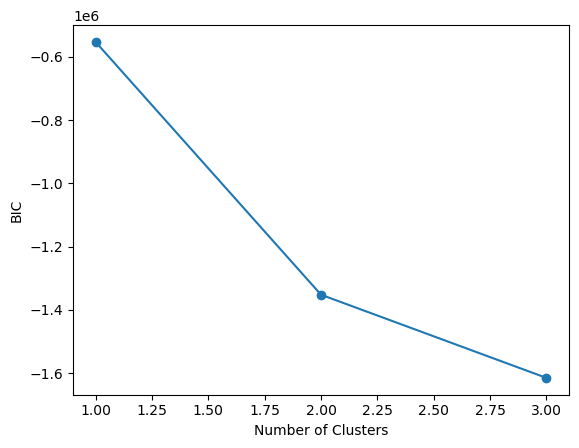

In [8]:
## plot BIC result as a function of the number of components
pGMM.plot_two_lists(n_comp_list_orig, bic_list_orig, "Number of Clusters", "BIC")

The routine is currently plotting cluster 0
The routine is currently plotting cluster 1
The routine is currently plotting cluster 2


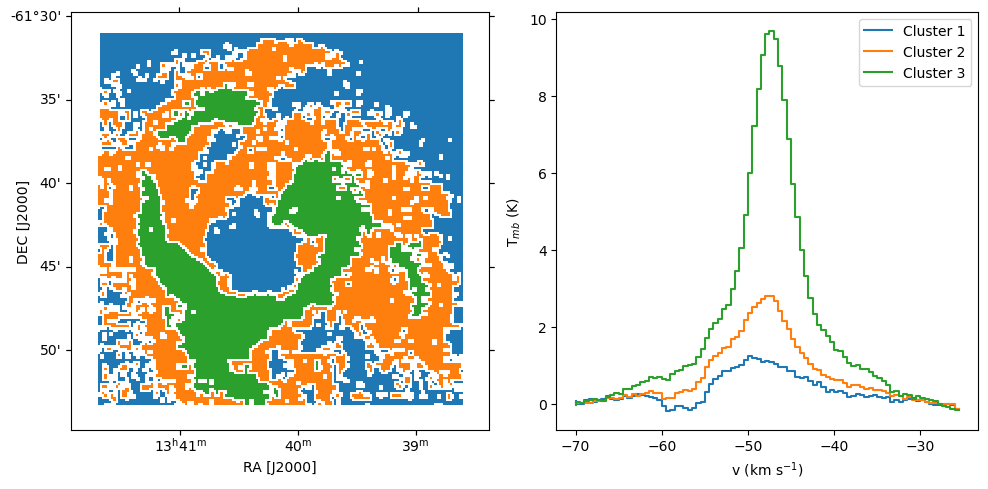

In [9]:
## Obtain the indices for the different clusters
cluster_inds = best_model_orig.predict(data_input)

## Map the spatial distribution of the different clusters
cluster_map = fGMM.map_spatial_cluster_distribution(cluster_inds, index_array, data.shape[2], data.shape[1])

## Create the velocity and resampled velocity array necessary for plotting
vel_arr = vax.create_velocity_array(min_velocity, max_velocity, dv)

## Plot the spectra associated with each cluster and indicate the spatial distribution of the identified spectral clusters
#pGMM.plot_clusters_and_spectra(data_reduced, cluster_map, vel_arr, w, plot_path = path_plots + save_name)
pGMM.plot_clusters_and_spectra(data_reduced, cluster_map, vel_arr, w)

The routine is currently plotting cluster 0
The routine is currently plotting cluster 1
The routine is currently plotting cluster 2


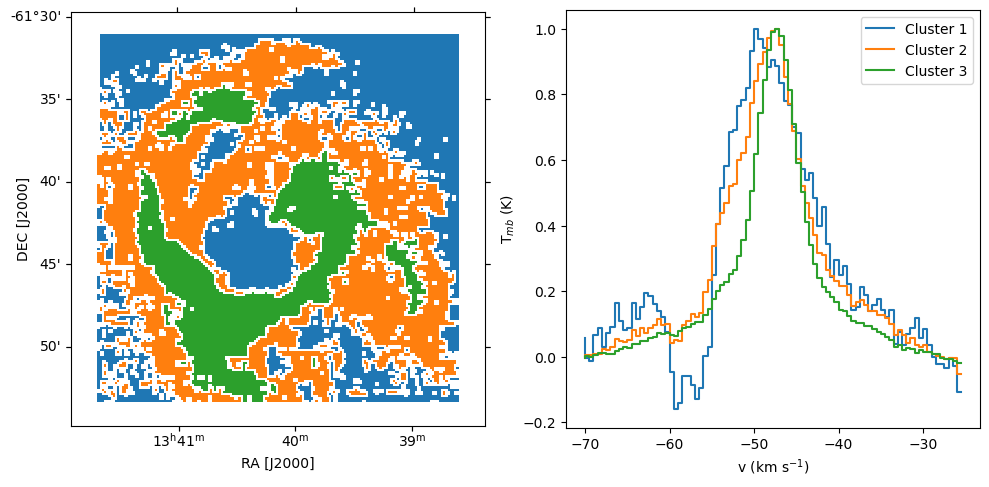

In [10]:
## Plot the normalized spectra associated with each cluster and their spatial distribution
pGMM.plot_clusters_and_spectra(data_reduced, cluster_map, vel_arr, w, normalize = True)

In [11]:
time_lists = []
n_comp_lists = []
bic_lists = []
best_models = []
for dv_resamp in dv_resamps:
    ## resample the spectral axis
    data_resamp = fGMM.resample_data(data_reduced, dv, dv_resamp, resamp_bool = resample_bool)
    
    ## prepare the data for GMM fitting
    index_array, data_input = fGMM.prepare_data(data_resamp, min_velocity, max_velocity, crval, dv_resamp, crpix)
    
    ## fit the GMM
    print(data_input.shape)
    (n_comp_list, bic_list, time_list, best_model) = fGMM.fit_GMM(data_input, n_comps_min1, n_comps_max1)
    
    time_lists.append(time_list)
    n_comp_lists.append(n_comp_list)
    bic_lists.append(bic_list)
    best_models.append(best_model)
 
#vel_arr_resamp = vax.create_velocity_array(min_velocity, max_velocity, dv_resamp)

NameError: name 'dv' is not defined

In [ ]:
## definition of linear and quadratic functions
def lin_func(x, a, b):
    return a*x + b

def quad_func(x, a, b):
    return a * x**2 + b

In [ ]:
x_plot_orig = np.linspace(n_comps_min, n_comps_max, num = 200)
x_ver_orig = [i for i in range(n_comps_min, n_comps_max)]

## fit the time evolution of the unresampled data with a linear function
popt_o, pcov_o = curve_fit(lin_func, n_comp_list_orig, time_list_orig)
lin_fit_orig = lin_func(x_plot_orig, popt_o[0], popt_o[1])
lin_ver_orig = [lin_func(val, popt_o[0], popt_o[1]) for val in x_ver_orig]

## fit the time evolution of the unresampled data with a quadratic function
popt_o, pcov_o = curve_fit(quad_func, n_comp_list_orig, time_list_orig)
quad_fit_orig = quad_func(x_plot_orig, popt_o[0], popt_o[1])
quad_ver_orig = [quad_func(val, popt_o[0], popt_o[1]) for val in x_ver_orig]

In [ ]:
## fit the linear and quadratic function for the time evolution
x_plot = np.linspace(n_comps_min1, n_comps_max1, num = 200)
x_ver = [i for i in range(n_comps_min1, n_comps_max1)]
lin_fits = []
lin_vers = []
quad_fits = []
quad_vers = []
for time_list, n_comp in zip(time_lists, n_comp_lists):
    ## fit the linear function and store the predicted function for plotting
    popt, pcov = curve_fit(lin_func, n_comp, time_list)
    lin_fits.append(lin_func(x_plot, popt[0], popt[1]))
    lin_vers.append([lin_func(val, popt[0], popt[1]) for val in x_ver])
    
    ## fit the quadratic functions and store the predicted function for plotting
    popt, pcov = curve_fit(quad_func, n_comp, time_list)
    quad_fits.append(quad_func(x_plot, popt[0], popt[1]))
    quad_vers.append([quad_func(val, popt[0], popt[1]) for val in x_ver])

In [ ]:
## study the time evolution for the different resampling values with a linear fit
plt.plot(n_comp_list_orig, time_list_orig, 'o-', label = '{dv} = {vel} km {sm}'.format(dv = '$\Delta$v', vel = round(dv, 1), sm = 's$^{-1}$'))
plt.plot(x_plot_orig, lin_fit_orig, 'k-')
for time_list, n_comp, dv_resamp, lin_fit in zip(time_lists, n_comp_lists, dv_resamps, lin_fits):
    ## plot the needed time
    plt.plot(n_comp, time_list, 'o-', label = '{dv} = {vel} km {sm}'.format(dv = '$\Delta$v', vel = round(dv_resamp, 1), sm = 's$^{-1}$'))
    
    ## plot the fitted linear function 
    plt.plot(x_plot, lin_fit, 'k-')
    
plt.xlabel('number of GMM components')
plt.ylabel('fitting time (s)')
plt.legend()
#plt.savefig('plots/time_linfit_resample.pdf', dpi = 300)
plt.show()

In [ ]:
## study the time evolution for the different resampling values with a quadratic fit
plt.plot(n_comp_list_orig, time_list_orig, 'o-', label = '{dv} = {vel} km {sm}'.format(dv = '$\Delta$v', vel = round(dv, 1), sm = 's$^{-1}$'))
plt.plot(x_plot_orig, quad_fit_orig, 'k-')
for time_list, n_comp, dv_resamp, quad_fit in zip(time_lists, n_comp_lists, dv_resamps, quad_fits):
    ## plot the needed time
    plt.plot(n_comp, time_list, 'o-', label = '{dv} = {vel} km {sm}'.format(dv = '$\Delta$v', vel = round(dv_resamp, 1), sm = 's$^{-1}$'))
    
    ## plot the fitted linear function 
    plt.plot(x_plot, quad_fit, 'k-')
    
plt.xlabel('number of GMM components')
plt.ylabel('fitting time (s)')
plt.legend()
#plt.savefig('plots/time_quadfit_resample.pdf', dpi = 300)
plt.show()

In [ ]:
## perform KS-test
## for the original bin sampling
print(kstest(time_list_orig, lin_fit_orig))
print(kstest(time_list_orig, quad_fit_orig))

In [ ]:
## perform KS-test
## for the original bin sampling

for time_list, lin_fit, quad_fit in zip(time_lists, lin_fits, quad_fits):
    print(kstest(time_list, lin_fit))
    print(kstest(time_list, quad_fit))

In [ ]:
## make predictions for time cost
for idx in range(11, 21):
    print("{num}: {t} seconds".format(num = idx, t = quad_func(idx, popt_o[0], popt_o[1])))

In [ ]:
## print the BIC evolution
plt.plot(n_comp_list_orig, bic_list_orig, 'o-', label = '{dv} = {vel} km {sm}'.format(dv = '$\Delta$v', vel = round(dv, 1), sm = 's$^{-1}$'))
for bic_list, n_comp, dv_resamp in zip(bic_lists, n_comp_lists, dv_resamps):
    plt.plot(n_comp, bic_list, 'o-', label = '{dv} = {vel} km {sm}'.format(dv = '$\Delta$v', vel = round(dv_resamp, 1), sm = 's$^{-1}$'))

plt.xlabel('number of GMM components')
plt.ylabel('BIC')
plt.legend()
#plt.savefig('plots/bic_evol_resample.pdf', dpi = 300)
plt.show()

In [ ]:
## print the best models
for best_model in best_models:
    print(best_model)